# Neural Network

Xây dựng neural network với hai tầng ẩn (hidden layer).
Các trọng số và mối liên hệ giữa các tầng ẩn được thiết lập
và cài đặt bằng tay.

## Neural Network Overview

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>

## MNIST Dataset Overview

MNIST là bộ dữ liệu chứa các ảnh là các ký tự viết tay, chia thành 2 phần, 60000 ảnh dùng để huấn luyện và 10000 ảnh dùng để kiểm thử. Kích thước các ảnh là 28x28, giá trị các pixel thuộc [0,255]


![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [2]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\ADMIN\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf

In [4]:
# MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).
num_features = 784 # data features (img shape: 28*28).

# Network parameters.
n_hidden_1 = 128 # 1st layer number of neurons.
n_hidden_2 = 256 # 2nd layer number of neurons.

In [5]:
# Chuẩn bị dữ liệu
from tensorflow.keras.datasets import mnist #tap hop chu viet tay
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Chuyển đổi sang định dạng float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]).T, x_test.reshape([-1, num_features]).T
#mạng neural đơn giản yêu cầu 1 vector chứ o phải ma trận hình ảnh
# Chuẩn hóa ảnh từ from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [6]:
m = x_train.shape[0]

In [7]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

In [8]:
def init_params():
    W1 = np.random.rand(n_hidden_1, 784) - 0.5
    b1 = np.random.rand(n_hidden_1, 1) - 0.5
    W2 = np.random.rand(num_classes, n_hidden_1) - 0.5
    b2 = np.random.rand(num_classes, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    tính giá trị cross entropy giữa targets và predictions. 
    Input: predictions (N, k)
           targets (N, k)        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon) #clip để tránh không có số 0
    N = predictions.shape[0] 
    ce = -np.sum(targets*np.log(predictions+1e-9))/N #tìm mean
    return ce
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1 #dense1
    A1 = ReLU(Z1) # lọc dense1 theo hidden activation
    Z2 = W2.dot(A1) + b2 #dense2 lấy kqa từ dense1
    A2 = softmax(Z2) #softmax - log + chuẩn hóa
    return Z1, A1, Z2, A2

def ReLU_deriv(Z): #hàm ReLU hidden activation
    return Z > 0

def one_hot(Y): #one_hot encoding
    one_hot_Y = np.zeros((Y.size, Y.max() + 1)) #tạo ma trận số 0 với Y là số lượng nhãn (rows), Y max + 1 (columne) vì từ 0
    one_hot_Y[np.arange(Y.size), Y] = 1 #softmax_outputs[range(len(softmax_outputs)), class_target]
    one_hot_Y = one_hot_Y.T # chuyển vị
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y): #using gradient 
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [35]:
losses = []
accuracies = []
def get_predictions(A2):
    return np.argmax(A2, 0) #chọn nhãn có giá trị cao nhất

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size #tính probabilities

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        predictions = get_predictions(A2)
        losses.append(cross_entropy(predictions, Y))
        accuracies.append(float(get_accuracy(predictions, Y)))
        if i % 10 == 9:
            print("Iteration: ", i+1)
            predictions = get_predictions(A2)
            print('Accuracy: %.3f' %(get_accuracy(predictions, Y)))
            print('Iteration: %d, accuracy: %.3f' %(i + 1, get_accuracy(predictions, Y)))
    return W1, b1, W2, b2

In [36]:
alpha = 0.01
n_epoch = 100
W1, b1, W2, b2 = gradient_descent(x_train, y_train, alpha, n_epoch)
print(accuracies)


[6 1 9 ... 6 3 4] [5 0 4 ... 5 6 8]
[0 0 9 ... 0 0 8] [5 0 4 ... 5 6 8]
[3 8 9 ... 3 4 1] [5 0 4 ... 5 6 8]
[5 8 4 ... 9 4 8] [5 0 4 ... 5 6 8]
[5 9 8 ... 3 4 8] [5 0 4 ... 5 6 8]
[5 5 8 ... 3 8 8] [5 0 4 ... 5 6 8]
[5 5 8 ... 3 8 8] [5 0 4 ... 5 6 8]
[5 0 8 ... 3 8 1] [5 0 4 ... 5 6 8]
[5 0 8 ... 3 9 1] [5 0 4 ... 5 6 8]
[5 0 8 ... 3 9 1] [5 0 4 ... 5 6 8]
Iteration:  10
[5 0 8 ... 3 9 1] [5 0 4 ... 5 6 8]
Accuracy: 0.480
[5 0 8 ... 3 9 1] [5 0 4 ... 5 6 8]
Iteration: 10, accuracy: 0.480
[5 0 8 ... 3 9 1] [5 0 4 ... 5 6 8]
[5 0 9 ... 3 9 1] [5 0 4 ... 5 6 8]
[5 0 9 ... 3 9 1] [5 0 4 ... 5 6 8]
[5 0 9 ... 3 9 1] [5 0 4 ... 5 6 8]
[5 0 9 ... 5 6 1] [5 0 4 ... 5 6 8]
[5 0 9 ... 5 6 1] [5 0 4 ... 5 6 8]
[5 0 9 ... 5 6 1] [5 0 4 ... 5 6 8]
[5 0 9 ... 5 6 8] [5 0 4 ... 5 6 8]
[5 0 9 ... 5 6 8] [5 0 4 ... 5 6 8]
[5 0 9 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration:  20
[5 0 9 ... 5 6 8] [5 0 4 ... 5 6 8]
Accuracy: 0.692
[5 0 9 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration: 20, accuracy: 0.692
[5 0 9 ... 5

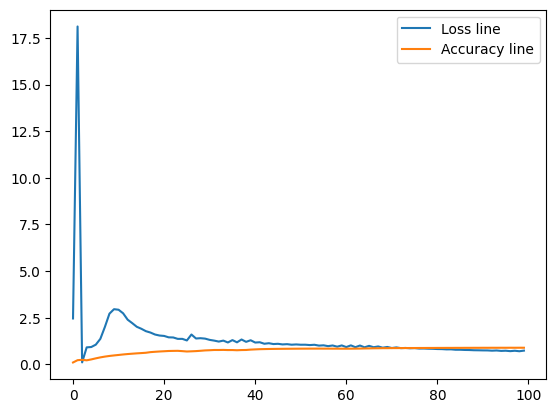

In [37]:
# Biểu đồ biểu diễn độ biến thiên của hàm mất mát qua các vòng lặp
plt.plot([i for i in range(len(losses))], losses, label='Loss line')
_, _, _, A2_test = forward_prop(W1, b1, W2, b2, x_test)  # forward prop trên tập kiểm thử
predictions_test = get_predictions(A2_test)
plt.plot([i for i in range(len(accuracies))], accuracies, label='Accuracy line')
plt.legend()
plt.show()